# **UNEMPLOYMENT RATE PREDICTOR**

In [12]:
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler

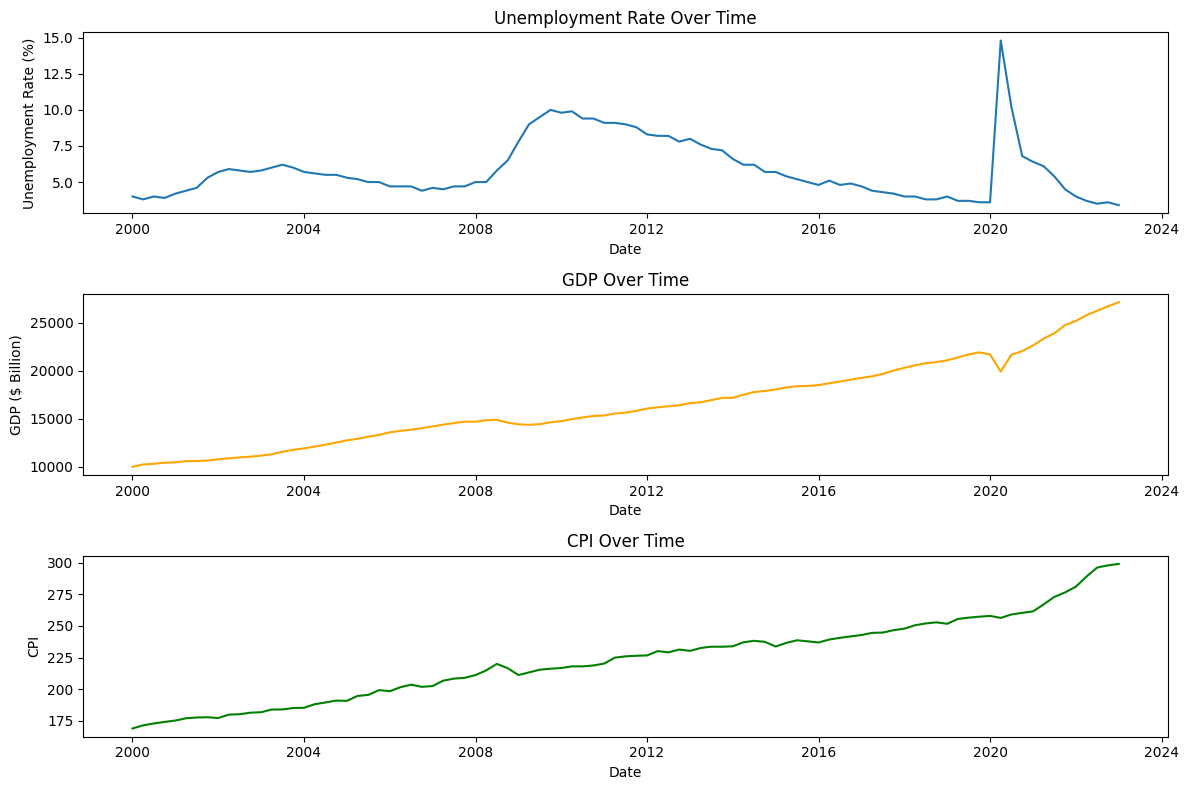

In [13]:
# Fetch the unemployment rate, GDP, and CPI data from FRED
unemployment_data = web.DataReader('UNRATE', 'fred', start='2000-01-01', end='2023-01-01')
gdp_data = web.DataReader('GDP', 'fred', start='2000-01-01', end='2023-01-01')
cpi_data = web.DataReader('CPIAUCNS', 'fred', start='2000-01-01', end='2023-01-01')

# Merge the datasets into a single DataFrame
data = pd.concat([unemployment_data, gdp_data, cpi_data], axis=1)
data.columns = ['Unemployment Rate', 'GDP', 'CPI']
data.dropna(inplace=True)  # Drop rows with missing values

# Plot the datasets
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(data['Unemployment Rate'], label='Unemployment Rate')
plt.title('Unemployment Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')

plt.subplot(3, 1, 2)
plt.plot(data['GDP'], label='GDP', color='orange')
plt.title('GDP Over Time')
plt.xlabel('Date')
plt.ylabel('GDP ($ Billion)')

plt.subplot(3, 1, 3)
plt.plot(data['CPI'], label='Consumer Price Index (CPI)', color='green')
plt.title('CPI Over Time')
plt.xlabel('Date')
plt.ylabel('CPI')
plt.tight_layout()
plt.show()

In [14]:
class EconomicIndicatorsDataset(Dataset):
    def __init__(self, data, seq_length):
        self.data = data
        self.seq_length = seq_length

    def __len__(self):
        return len(self.data) - self.seq_length

    def __getitem__(self, index):
        x = self.data[index:index + self.seq_length].values
        y = self.data.iloc[index + self.seq_length, 0]
        return torch.tensor(x, dtype=torch.float32), torch.tensor([y], dtype=torch.float32)

In [15]:
# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data)

# Create dataset and dataloaders
seq_length = 12  # Use past 12 months to predict the next month
dataset = EconomicIndicatorsDataset(pd.DataFrame(scaled_data), seq_length)
train_size = int(len(dataset) * 0.8)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, len(dataset) - train_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [16]:
# Define the Transformer model
class TransformerModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, seq_length = 12):
        super(TransformerModel, self).__init__()
        # Linear layer to project input to d_model dimensions
        self.fc_in = nn.Linear(input_size, hidden_size)
        self.positional_encoding = nn.Parameter(torch.randn(1, seq_length, hidden_size))

        self.transformer = nn.Transformer(d_model=hidden_size,
                                          nhead=8,
                                          num_encoder_layers=num_layers,
                                          num_decoder_layers=num_layers,
                                          dim_feedforward=hidden_size//2,
                                          batch_first=True)


        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, src):
        src = self.fc_in(src)
        src = src + self.positional_encoding
        transformer_output = self.transformer(src, src)
        output = self.fc(transformer_output[:, -1, :])  # Predict only the last step
        return output, transformer_output

Epoch [5/60], Loss: 0.1759
Epoch [10/60], Loss: 0.1265
Epoch [15/60], Loss: 0.1171
Epoch [20/60], Loss: 0.0799
Epoch [25/60], Loss: 0.0662
Epoch [30/60], Loss: 0.0893
Epoch [35/60], Loss: 0.0819
Epoch [40/60], Loss: 0.0639
Epoch [45/60], Loss: 0.0596
Epoch [50/60], Loss: 0.0575
Epoch [55/60], Loss: 0.0481
Epoch [60/60], Loss: 0.0433


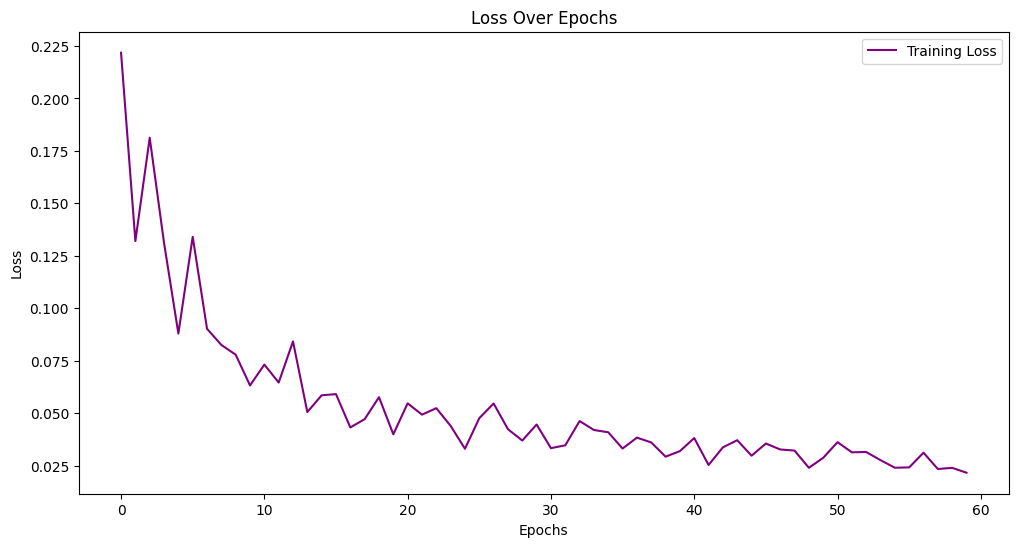

In [21]:
# Hyperparameters
input_size = 3  # Unemployment rate, GDP, CPI
hidden_size = 64
num_layers = 1
epochs = 60
learning_rate = 0.001

# Initialize the model, criterion, and optimizer
model = TransformerModel(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Training the model
losses = []
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        # batch_x = batch_x.transpose(0, 1)  # Transform to [seq_length, batch_size, input_size]
        predictions, _ = model(batch_x)
        # print(predictions.shape, batch_y.unsqueeze(-1).shape)
        loss = criterion(predictions, batch_y)  # Ensure shapes match
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(train_loader))
    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch + 1}/{epochs}], Loss: {total_loss:.4f}')

# Plotting training loss
plt.figure(figsize=(12, 6))
plt.plot(losses, color='purple', label='Training Loss')
plt.title('Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


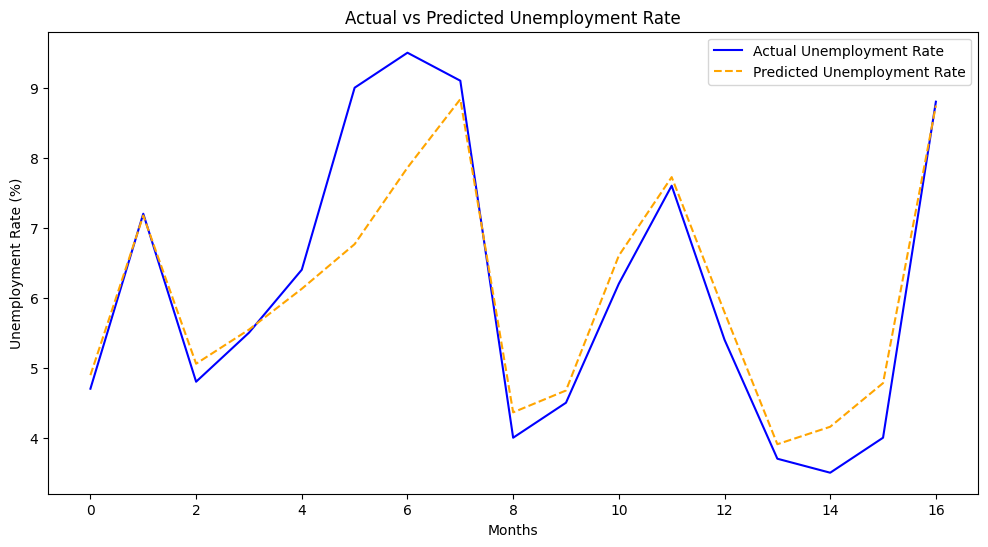

In [22]:
# Evaluation
model.eval()
predictions, actuals = [], []
attention_weights = []
with torch.no_grad():
    for batch_x, batch_y in test_loader:
        # batch_x = batch_x.transpose(0, 1)  # Transform to [seq_length, batch_size, input_size]
        preds, attn_output = model(batch_x)
        predictions.append(preds.numpy())
        actuals.append(batch_y.numpy())
        attention_weights.append(attn_output)

predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

# Inverse transform to get original scale
predictions = scaler.inverse_transform(np.concatenate([predictions, np.zeros((predictions.shape[0], 2))], axis=1))[:, 0]
actuals = scaler.inverse_transform(np.concatenate([actuals.reshape(-1, 1), np.zeros((actuals.shape[0], 2))], axis=1))[:, 0]

# Plotting predictions vs actual
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual Unemployment Rate', color='blue')
plt.plot(predictions, label='Predicted Unemployment Rate', color='orange', linestyle='dashed')
plt.title('Actual vs Predicted Unemployment Rate')
plt.xlabel('Months')
plt.ylabel('Unemployment Rate (%)')
plt.legend()
plt.show()